In [1]:
import pandas as pd
import numpy as np
import math
from itertools import combinations
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings('ignore')
import subprocess
from adjustText import adjust_text
import scanpy as sc
sc.settings.verbosiforty = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import anndata as ad
import scipy.sparse as sp
import scanpy.external as sce

scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.6 pynndescent==0.5.13


In [15]:
cd8_merge_clean = pd.read_csv('cd8_merge_clean.csv',sep = '\t')
cd4_merge_clean = pd.read_csv('cd4_merge_clean.csv',sep = '\t')

## Figure 4B 

In [12]:
tot_tcell = cd8_merge_clean.groupby(by = ['patient','timepoint']).count()[['total_counts']].reset_index()
tot_tcell['id'] = tot_tcell['timepoint'].astype(str)+"|" + tot_tcell['patient'].astype(str)
tcr_count = cd8_merge_clean.groupby(by = ['patient','timepoint','beta_cdr3'])[['total_counts']].count().reset_index()
tcr_count['id'] = tcr_count['timepoint'].astype(str)+"|" + tcr_count['patient'].astype(str)

ratio = pd.concat([tot_tcell.groupby(by = ['id','patient','timepoint'])[['total_counts']].mean(), tcr_count.groupby(by = ['id','patient','timepoint']).count()[['beta_cdr3']]],axis= 1)
ratio['ratio'] = ratio['beta_cdr3']/ratio['total_counts']*100
ratio = ratio.reset_index()
ratio = ratio[ratio['id']!='C1D1 predose|10606']
ratio.loc[ratio['timepoint'] == 'Screening','timepoint'] = 'C1D1 predose'
ratio.loc[ratio['timepoint'].isin(['C11D1','C16D1']),'timepoint'] = 'EOT'
ratio['patient'] = ratio['patient'].astype(str)

cd8_ratio = [] 
for p in ['11414', '10606', '11010', '10909', '10808',]:
    tmp = ratio[ratio['patient'] == p].sort_values(by = ['timepoint'])
    tmp['time_index'] = np.arange(tmp.shape[0])
    cd8_ratio.append(tmp)
cd8_ratio = pd.concat(cd8_ratio)
cd8_ratio['response'] = 'Non-responder'
cd8_ratio.loc[cd8_ratio['patient'].isin(['11414', '10606',]),'response'] = 'Responder'

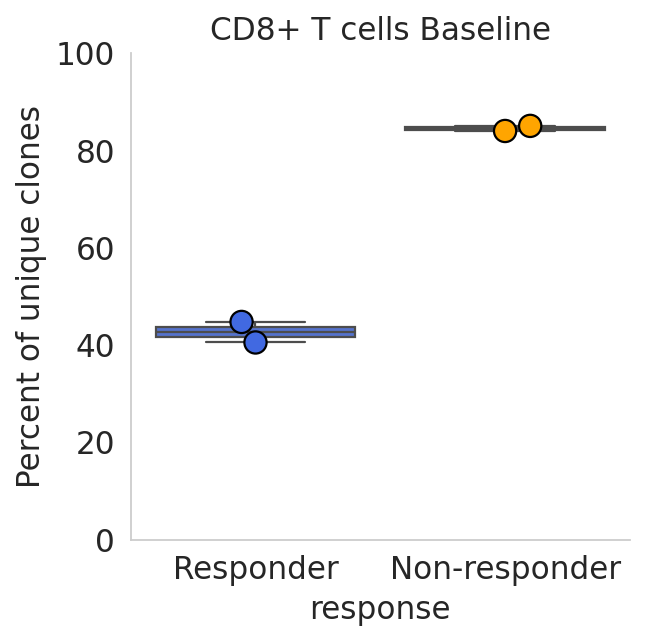

In [14]:
#cd8_ratio = pd.read_csv('./human_output/cd8_clonality_c1d1.csv',sep ='\t')

sns.boxplot(data = cd8_ratio[cd8_ratio['timepoint'].str.contains('C1D1')],x = 'response',y = 'ratio', palette = {'Responder':'royalblue','Non-responder':'orange'})
sns.swarmplot(data = cd8_ratio[cd8_ratio['timepoint'].str.contains('C1D1')],s = 10, linewidth = 1, edgecolor = 'black',
              x = 'response',y = 'ratio',palette = {'Responder':'royalblue','Non-responder':'orange'})
plt.ylabel('Percent of unique clones')
plt.title('CD8+ T cells Baseline')
plt.ylim(0,100)
sns.despine(top = True)
plt.show()


In [16]:
tot_tcell = cd4_merge_clean.groupby(by = ['patient','timepoint']).count()[['total_counts']].reset_index()
tot_tcell['id'] = tot_tcell['timepoint'].astype(str)+"|" + tot_tcell['patient'].astype(str)
tcr_count = cd4_merge_clean.groupby(by = ['patient','timepoint','beta_cdr3'])[['total_counts']].count().reset_index()
tcr_count['id'] = tcr_count['timepoint'].astype(str)+"|" + tcr_count['patient'].astype(str)

ratio = pd.concat([tot_tcell.groupby(by = ['id','patient','timepoint'])[['total_counts']].mean(), tcr_count.groupby(by = ['id','patient','timepoint']).count()[['beta_cdr3']]],axis= 1)
ratio['ratio'] = ratio['beta_cdr3']/ratio['total_counts']*100
ratio = ratio.reset_index()
ratio = ratio[ratio['id']!='C1D1 predose|10606']
ratio.loc[ratio['timepoint'] == 'Screening','timepoint'] = 'C1D1 predose'
ratio.loc[ratio['timepoint'].isin(['C11D1','C16D1']),'timepoint'] = 'EOT'
ratio['patient'] = ratio['patient'].astype(str)
cd4_ratio = [] 
for p in ['11414', '10606', '11010', '10909', '10808',]:
    tmp = ratio[ratio['patient'] == p].sort_values(by = ['timepoint'])
    tmp['time_index'] = np.arange(tmp.shape[0])
    cd4_ratio.append(tmp)
cd4_ratio = pd.concat(cd4_ratio)
cd4_ratio['response'] = 'Non-responder'
cd4_ratio.loc[cd4_ratio['patient'].isin(['11414', '10606',]),'response'] = 'Responder'

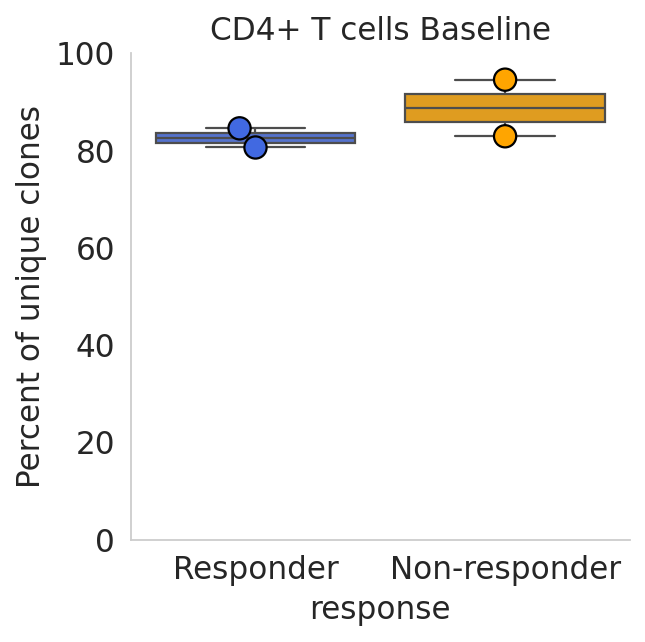

In [17]:
#cd8_ratio = pd.read_csv('./human_output/cd4_clonality_c1d1.csv',sep ='\t')

sns.boxplot(data = cd4_ratio[cd4_ratio['timepoint'].str.contains('C1D1')],x = 'response',y = 'ratio', palette = {'Responder':'royalblue','Non-responder':'orange'})
sns.swarmplot(data = cd4_ratio[cd4_ratio['timepoint'].str.contains('C1D1')],s = 10, linewidth = 1, edgecolor = 'black',
              x = 'response',y = 'ratio',palette = {'Responder':'royalblue','Non-responder':'orange'})
plt.ylabel('Percent of unique clones')
plt.title('CD4+ T cells Baseline')
plt.ylim(0,100)
sns.despine(top = True)
plt.show()

## Figure 4C

In [20]:
cd8_merge_clean['patient']= cd8_merge_clean['patient'].astype(str)

In [21]:
from fisher_vec import vec_fisher_exact
from scipy.stats import fisher_exact

patient= '11414'
pf = cd8_merge_clean[cd8_merge_clean['patient'] == patient]
pf['timepoint'] = pf['timepoint'].astype(str)
pf['patient'] = pf['patient'].astype(str)

base = pf.groupby(by = ['timepoint'])[['ID']].count().reset_index()
count = pf.groupby(by = ['timepoint','beta_cdr3'])[['ID']].count().reset_index()
inputdf = count.merge(base,left_on = 'timepoint',right_on = 'timepoint')
inputdf['ID_x'] = inputdf['ID_x']
inputdf['freq'] = inputdf['ID_x']/inputdf['ID_y']
inputdf['member_no_target'] = inputdf['ID_y']-inputdf['ID_x']

e_list = []
for c in combinations(['C11D1','C2D8','C2D1','C1D4','C1D1'], 2 ):
    t2 = c[0]
    t1 = c[1]
    member = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='ID_x')[[t2]] 
    target_nonmember = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='member_no_target')[[t2]] 
    
    member_nontarget = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='ID_x')[[t1]] 
    background = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='member_no_target')[[t1]] 
    
    member[member.isna()] = 0
    target_nonmember[target_nonmember.isna()] = 0
    member_nontarget[member_nontarget.isna()] = 0
    background[background.isna()] = 0
    
    enrich = pd.concat([ member, member_nontarget, target_nonmember, background],axis= 1)
    enrich.columns = ['member','member_nontarget','target_nonmember','background']
    enrich[enrich.isna()]= 0

    enrich['tot'] = enrich.sum(axis= 1)
    enrich = enrich[enrich['tot']>0].drop(columns = ['tot'])
    enrich = enrich[(enrich['member']>0)|(enrich['member_nontarget']>0)]
    
    oddsratio, pvalue = vec_fisher_exact(enrich['member'].values, 
                                         enrich['member_nontarget'].values, 
                                         enrich['target_nonmember'].values, 
                                         enrich['background'].values, alternative = 'greater')
    
    enrich['pval'] = pvalue
    enrich['fdr'] = fdrcorrection(enrich['pval'])[1]
    enrich['patient'] = patient
    enrich['post'] = t2
    enrich['baseline'] = t1
    e_list.append(enrich)
p1_enrich_df = pd.concat(e_list).sort_values(by = ['fdr'])


patient= '10606'

pf = cd8_merge_clean[cd8_merge_clean['patient'] == patient]
pf['timepoint'] = pf['timepoint'].astype(str)
pf['patient'] = pf['patient'].astype(str)

base = pf.groupby(by = ['timepoint'])[['ID']].count().reset_index()
count = pf.groupby(by = ['timepoint','beta_cdr3'])[['ID']].count().reset_index()
inputdf = count.merge(base,left_on = 'timepoint',right_on = 'timepoint')
inputdf['ID_x'] = inputdf['ID_x']
inputdf['freq'] = inputdf['ID_x']/inputdf['ID_y']
inputdf['member_no_target'] = inputdf['ID_y']-inputdf['ID_x']

e_list = []
for c in combinations(['Day 28 FU','C2D8','C2D1 predose','C1D8','Screening'], 2 ):
    t2 = c[0]
    t1 = c[1]
    member = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='ID_x')[[t2]] 
    target_nonmember = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='member_no_target')[[t2]] 
    
    member_nontarget = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='ID_x')[[t1]] 
    background = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='member_no_target')[[t1]] 
    
    member[member.isna()] = 0
    target_nonmember[target_nonmember.isna()] = 0
    member_nontarget[member_nontarget.isna()] = 0
    background[background.isna()] = 0
    
    enrich = pd.concat([ member, member_nontarget, target_nonmember, background],axis= 1)
    enrich.columns = ['member','member_nontarget','target_nonmember','background']
    enrich[enrich.isna()]= 0

    enrich['tot'] = enrich.sum(axis= 1)
    enrich = enrich[enrich['tot']>0].drop(columns = ['tot'])
    enrich = enrich[(enrich['member']>0)|(enrich['member_nontarget']>0)]
    
    oddsratio, pvalue = vec_fisher_exact(enrich['member'].values, 
                                         enrich['member_nontarget'].values, 
                                         enrich['target_nonmember'].values, 
                                         enrich['background'].values, alternative = 'greater')
    
    enrich['pval'] = pvalue
    enrich['fdr'] = fdrcorrection(enrich['pval'])[1]
    enrich['patient'] = patient
    enrich['post'] = t2
    enrich['baseline'] = t1
    e_list.append(enrich)
p2_enrich_df = pd.concat(e_list).sort_values(by = ['fdr'])


patient= '10909'
pf = cd8_merge_clean[cd8_merge_clean['patient'] == patient]
pf['timepoint'] = pf['timepoint'].astype(str)
pf['patient'] = pf['patient'].astype(str)

base = pf.groupby(by = ['timepoint'])[['ID']].count().reset_index()
count = pf.groupby(by = ['timepoint','beta_cdr3'])[['ID']].count().reset_index()
inputdf = count.merge(base,left_on = 'timepoint',right_on = 'timepoint')
inputdf['ID_x'] = inputdf['ID_x']
inputdf['freq'] = inputdf['ID_x']/inputdf['ID_y']
inputdf['member_no_target'] = inputdf['ID_y']-inputdf['ID_x']

e_list = []
for c in combinations(['C16D1' , 'C2D8','C2D1 predose','C1D8', 'C1D1 predose',  ], 2 ):
    t2 = c[0]
    t1 = c[1]
    member = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='ID_x')[[t2]] 
    target_nonmember = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='member_no_target')[[t2]] 
    
    member_nontarget = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='ID_x')[[t1]] 
    background = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='member_no_target')[[t1]] 
    
    member[member.isna()] = 0
    target_nonmember[target_nonmember.isna()] = 0
    member_nontarget[member_nontarget.isna()] = 0
    background[background.isna()] = 0
    
    enrich = pd.concat([ member, member_nontarget, target_nonmember, background],axis= 1)
    enrich.columns = ['member','member_nontarget','target_nonmember','background']
    enrich[enrich.isna()]= 0

    enrich['tot'] = enrich.sum(axis= 1)
    enrich = enrich[enrich['tot']>0].drop(columns = ['tot'])
    enrich = enrich[(enrich['member']>0)|(enrich['member_nontarget']>0)]
    
    oddsratio, pvalue = vec_fisher_exact(enrich['member'].values, 
                                         enrich['member_nontarget'].values, 
                                         enrich['target_nonmember'].values, 
                                         enrich['background'].values, alternative = 'greater')
    
    enrich['pval'] = pvalue
    enrich['fdr'] = fdrcorrection(enrich['pval'])[1]
    enrich['patient'] = patient
    enrich['post'] = t2
    enrich['baseline'] = t1
    e_list.append(enrich)
p3_enrich_df = pd.concat(e_list).sort_values(by = ['fdr'])


patient= '10808'

pf = cd8_merge_clean[cd8_merge_clean['patient'] == patient]
pf['timepoint'] = pf['timepoint'].astype(str)
pf['patient'] = pf['patient'].astype(str)

base = pf.groupby(by = ['timepoint'])[['ID']].count().reset_index()
count = pf.groupby(by = ['timepoint','beta_cdr3'])[['ID']].count().reset_index()
inputdf = count.merge(base,left_on = 'timepoint',right_on = 'timepoint')
inputdf['ID_x'] = inputdf['ID_x']
inputdf['freq'] = inputdf['ID_x']/inputdf['ID_y']
inputdf['member_no_target'] = inputdf['ID_y']-inputdf['ID_x']

e_list = []
for c in combinations([ 'C2D8' , 'C2D1 predose','C1D8', 'C1D1 predose',  ], 2 ):
    t2 = c[0]
    t1 = c[1]
    member = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='ID_x')[[t2]] 
    target_nonmember = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='member_no_target')[[t2]] 
    
    member_nontarget = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='ID_x')[[t1]] 
    background = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='member_no_target')[[t1]] 
    
    member[member.isna()] = 0
    target_nonmember[target_nonmember.isna()] = 0
    member_nontarget[member_nontarget.isna()] = 0
    background[background.isna()] = 0
    
    enrich = pd.concat([ member, member_nontarget, target_nonmember, background],axis= 1)
    enrich.columns = ['member','member_nontarget','target_nonmember','background']
    enrich[enrich.isna()]= 0

    enrich['tot'] = enrich.sum(axis= 1)
    enrich = enrich[enrich['tot']>0].drop(columns = ['tot'])
    enrich = enrich[(enrich['member']>0)|(enrich['member_nontarget']>0)]
    
    oddsratio, pvalue = vec_fisher_exact(enrich['member'].values, 
                                         enrich['member_nontarget'].values, 
                                         enrich['target_nonmember'].values, 
                                         enrich['background'].values, alternative = 'greater')
    
    enrich['pval'] = pvalue
    enrich['fdr'] = fdrcorrection(enrich['pval'])[1]
    enrich['patient'] = patient
    enrich['post'] = t2
    enrich['baseline'] = t1
    e_list.append(enrich)
p4_enrich_df = pd.concat(e_list).sort_values(by = ['fdr'])

patient= '11010'
pf = cd8_merge_clean[cd8_merge_clean['patient'] == patient]
pf['timepoint'] = pf['timepoint'].astype(str)
pf['patient'] = pf['patient'].astype(str)

base = pf.groupby(by = ['timepoint'])[['ID']].count().reset_index()
count = pf.groupby(by = ['timepoint','beta_cdr3'])[['ID']].count().reset_index()
inputdf = count.merge(base,left_on = 'timepoint',right_on = 'timepoint')
inputdf['ID_x'] = inputdf['ID_x']
inputdf['freq'] = inputdf['ID_x']/inputdf['ID_y']
inputdf['member_no_target'] = inputdf['ID_y']-inputdf['ID_x']

e_list = []
for c in combinations(['EOT', 'C2D8', 'C2D1 predose', ], 2 ):
    t2 = c[0]
    t1 = c[1]
    member = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='ID_x')[[t2]] 
    target_nonmember = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='member_no_target')[[t2]] 
    
    member_nontarget = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='ID_x')[[t1]] 
    background = inputdf.pivot_table(columns =  'timepoint', index = 'beta_cdr3', values ='member_no_target')[[t1]] 
    
    member[member.isna()] = 0
    target_nonmember[target_nonmember.isna()] = 0
    member_nontarget[member_nontarget.isna()] = 0
    background[background.isna()] = 0
    
    enrich = pd.concat([ member, member_nontarget, target_nonmember, background],axis= 1)
    enrich.columns = ['member','member_nontarget','target_nonmember','background']
    enrich[enrich.isna()]= 0

    enrich['tot'] = enrich.sum(axis= 1)
    enrich = enrich[enrich['tot']>0].drop(columns = ['tot'])
    enrich = enrich[(enrich['member']>0)|(enrich['member_nontarget']>0)]
    
    oddsratio, pvalue = vec_fisher_exact(enrich['member'].values, 
                                         enrich['member_nontarget'].values, 
                                         enrich['target_nonmember'].values, 
                                         enrich['background'].values, alternative = 'greater')
    
    enrich['pval'] = pvalue
    enrich['fdr'] = fdrcorrection(enrich['pval'])[1]
    enrich['patient'] = patient
    enrich['post'] = t2
    enrich['baseline'] = t1
    e_list.append(enrich)
p5_enrich_df = pd.concat(e_list).sort_values(by = ['fdr'])



In [22]:
patient= '11414'
pf = cd8_merge_clean[cd8_merge_clean['patient'] == patient]
pf['timepoint'] = pf['timepoint'].astype(str)
pf['patient'] = pf['patient'].astype(str)

base = pf.groupby(by = ['timepoint'])[['ID']].count().reset_index()
count = pf.groupby(by = ['timepoint','beta_cdr3'])[['ID']].count().reset_index()
inputdf = count.merge(base,left_on = 'timepoint',right_on = 'timepoint')
inputdf['ID_x'] = inputdf['ID_x']
inputdf['freq'] = inputdf['ID_x']/inputdf['ID_y']
inputdf['member_no_target'] = inputdf['ID_y']-inputdf['ID_x']
p1_sum = inputdf[inputdf['beta_cdr3'].isin(p1_enrich_df[p1_enrich_df['pval']<0.05].index)].pivot_table(columns = 'timepoint', index = 'beta_cdr3', values ='freq')[['C1D1','C1D4','C2D1','C2D8','C11D1']]
p1_sum = inputdf[inputdf['beta_cdr3'].isin(p1_enrich_df[p1_enrich_df['pval']<0.05].index)].pivot_table(columns = 'timepoint', index = 'beta_cdr3', values ='freq')[['C1D1','C1D4','C2D1','C2D8','C11D1']]


patient= '10606'
pf = cd8_merge_clean[cd8_merge_clean['patient'] == patient]
pf['timepoint'] = pf['timepoint'].astype(str)
pf['patient'] = pf['patient'].astype(str)

base = pf.groupby(by = ['timepoint'])[['ID']].count().reset_index()
count = pf.groupby(by = ['timepoint','beta_cdr3'])[['ID']].count().reset_index()
inputdf = count.merge(base,left_on = 'timepoint',right_on = 'timepoint')
inputdf['ID_x'] = inputdf['ID_x']
inputdf['freq'] = inputdf['ID_x']/inputdf['ID_y']
inputdf['member_no_target'] = inputdf['ID_y']-inputdf['ID_x']
p2_sum = inputdf[inputdf['beta_cdr3'].isin(p2_enrich_df[p2_enrich_df['pval']<0.05].index)].pivot_table(columns = 'timepoint', index = 'beta_cdr3', values ='freq')[['Screening','C1D8','C2D1 predose','C2D8','Day 28 FU']]


patient= '10909'
pf = cd8_merge_clean[cd8_merge_clean['patient'] == patient]
pf['timepoint'] = pf['timepoint'].astype(str)
pf['patient'] = pf['patient'].astype(str)

base = pf.groupby(by = ['timepoint'])[['ID']].count().reset_index()
count = pf.groupby(by = ['timepoint','beta_cdr3'])[['ID']].count().reset_index()
inputdf = count.merge(base,left_on = 'timepoint',right_on = 'timepoint')
inputdf['ID_x'] = inputdf['ID_x']
inputdf['freq'] = inputdf['ID_x']/inputdf['ID_y']
inputdf['member_no_target'] = inputdf['ID_y']-inputdf['ID_x']
p3_sum = inputdf[inputdf['beta_cdr3'].isin(p3_enrich_df[p3_enrich_df['pval']<0.05].index)].pivot_table(columns = 'timepoint', index = 'beta_cdr3', values ='freq')[['C1D1 predose','C1D8',
                                                                                                                                                                   'C2D1 predose','C2D8','C16D1']]

patient= '10808'
pf = cd8_merge_clean[cd8_merge_clean['patient'] == patient]
pf['timepoint'] = pf['timepoint'].astype(str)
pf['patient'] = pf['patient'].astype(str)

base = pf.groupby(by = ['timepoint'])[['ID']].count().reset_index()
count = pf.groupby(by = ['timepoint','beta_cdr3'])[['ID']].count().reset_index()
inputdf = count.merge(base,left_on = 'timepoint',right_on = 'timepoint')
inputdf['ID_x'] = inputdf['ID_x']
inputdf['freq'] = inputdf['ID_x']/inputdf['ID_y']
inputdf['member_no_target'] = inputdf['ID_y']-inputdf['ID_x']
p4_sum = inputdf[inputdf['beta_cdr3'].isin(p4_enrich_df[p4_enrich_df['pval']<0.05].index)].pivot_table(columns = 'timepoint', index = 'beta_cdr3', values ='freq')

patient= '11010'
pf = cd8_merge_clean[cd8_merge_clean['patient'] == patient]
pf['timepoint'] = pf['timepoint'].astype(str)
pf['patient'] = pf['patient'].astype(str)

base = pf.groupby(by = ['timepoint'])[['ID']].count().reset_index()
count = pf.groupby(by = ['timepoint','beta_cdr3'])[['ID']].count().reset_index()
inputdf = count.merge(base,left_on = 'timepoint',right_on = 'timepoint')
inputdf['ID_x'] = inputdf['ID_x']
inputdf['freq'] = inputdf['ID_x']/inputdf['ID_y']
inputdf['member_no_target'] = inputdf['ID_y']-inputdf['ID_x']
p5_sum = inputdf[inputdf['beta_cdr3'].isin(p5_enrich_df[p5_enrich_df['pval']<0.05].index)].pivot_table(columns = 'timepoint', index = 'beta_cdr3', values ='freq')


In [23]:
p1_df = pd.DataFrame(p1_sum.sum()).reset_index()
p2_df = pd.DataFrame(p2_sum.sum()).reset_index()
p3_df = pd.DataFrame(p3_sum.sum()).reset_index()
p4_df = pd.DataFrame(p4_sum.sum()).reset_index()
p5_df = pd.DataFrame(p5_sum.sum()).reset_index()

mp1_df = pd.DataFrame(p1_sum.mean()).reset_index()
mp2_df = pd.DataFrame(p2_sum.mean()).reset_index()
mp3_df = pd.DataFrame(p3_sum.mean()).reset_index()
mp4_df = pd.DataFrame(p4_sum.mean()).reset_index()
mp5_df = pd.DataFrame(p5_sum.mean()).reset_index()

p1_df['log'] = np.log10(p1_df[0])
p2_df['log'] = np.log10(p2_df[0])
p3_df['log'] = np.log10(p3_df[0])
p4_df['log'] = np.log10(p4_df[0])
p5_df['log'] = np.log10(p5_df[0])


mp1_df['log'] = np.log10(mp1_df[0])
mp2_df['log'] = np.log10(mp2_df[0])
mp3_df['log'] = np.log10(mp3_df[0])
mp4_df['log'] = np.log10(mp4_df[0])
mp5_df['log'] = np.log10(mp5_df[0])

p1_sum_log = np.log10(p1_sum)
p2_sum_log = np.log10(p2_sum)
p3_sum_log = np.log10(p3_sum)
p4_sum_log = np.log10(p4_sum)
p5_sum_log = np.log10(p5_sum)

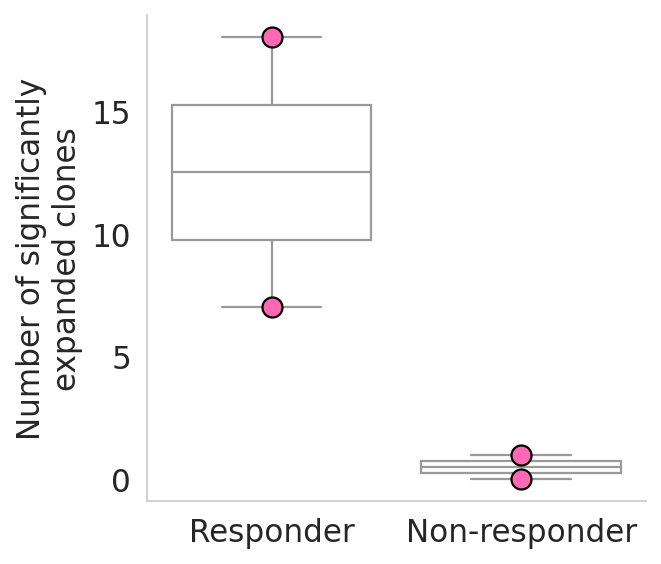

In [25]:
from scipy.stats import ttest_ind

df = pd.DataFrame( {'response': ['Responder','Responder','Non-responder','Non-responder',],
                    'patient': ['11414','10606','10909','10808'],
              'clone': [ p1_sum_log.shape[0], p2_sum_log.shape[0], p3_sum_log.shape[0],   p4_sum_log.shape[0],   ]})

sns.boxplot(data = df, x = 'response',y = 'clone', color = 'white', )
sns.swarmplot(data = df, x = 'response',y = 'clone', s = 9, linewidth =1, edgecolor = 'black', color = 'hotpink')
sns.despine(top = True)
plt.ylabel('Number of significantly\nexpanded clones')
plt.xlabel('')
plt.show()

## Figure 4D

In [28]:
cd8 = sc.read_h5ad('cd8_human_final.h5ad')

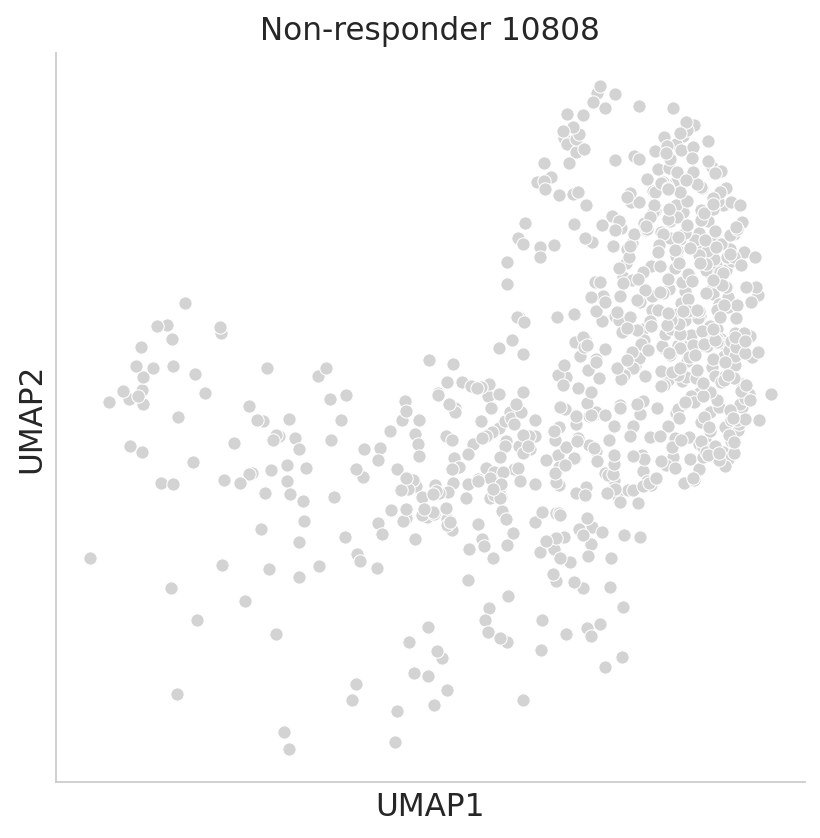

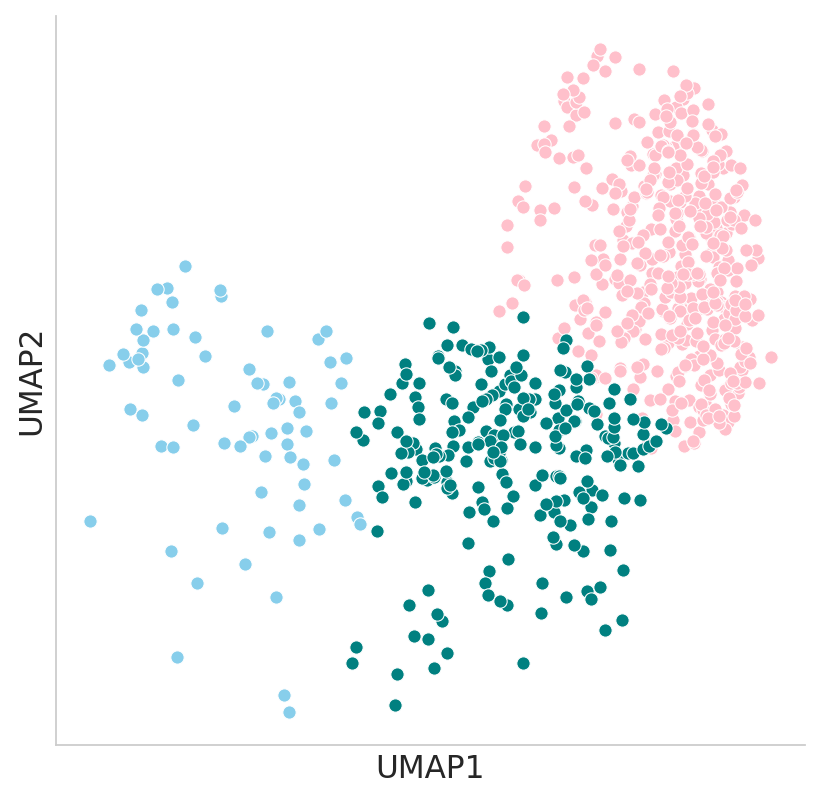

In [32]:
## patient 8
patient = cd8_merge_clean[cd8_merge_clean['patient'] =='10808' ]
patient['clone'] = patient['beta_cdr3'].isin(p4_sum.index)
cd8.obs['clone'] = cd8.obs.index.astype(str).isin(patient[patient['clone'] == True]['index'].values)
cd8.obs['clone'] = cd8.obs['clone'].astype(str)

tmp_df = cd8[cd8.obs['patient'] == '10808']
tmp = pd.DataFrame(tmp_df.obsm['X_umap'])
tmp.index = tmp_df.obs.index
tmp = pd.concat([ tmp, cd8.obs],axis= 1)

plt.subplots(figsize=(6,6))
plt.title('Non-responder 10808')
sns.scatterplot(data  = tmp[tmp['clone'] == 'False'],x =0,y = 1, color = 'lightgrey')
sns.scatterplot(data  = tmp[tmp['clone'] == 'True'],x=0,y =1,  color = 'red')
sns.despine(top = True)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

plt.subplots(figsize=(6,6))
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Effector'],x =0,y = 1, color = 'pink')
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Effector memory'],x=0,y =1,  color = 'teal')
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Stem-like'],x=0,y =1,  color = 'skyblue')
sns.despine(top = True)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

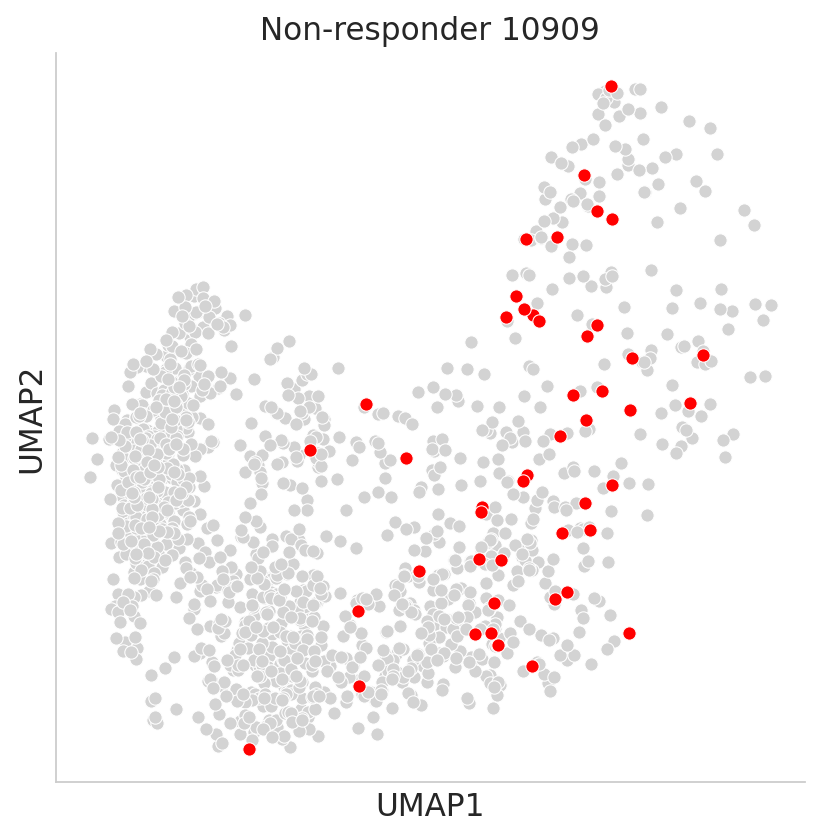

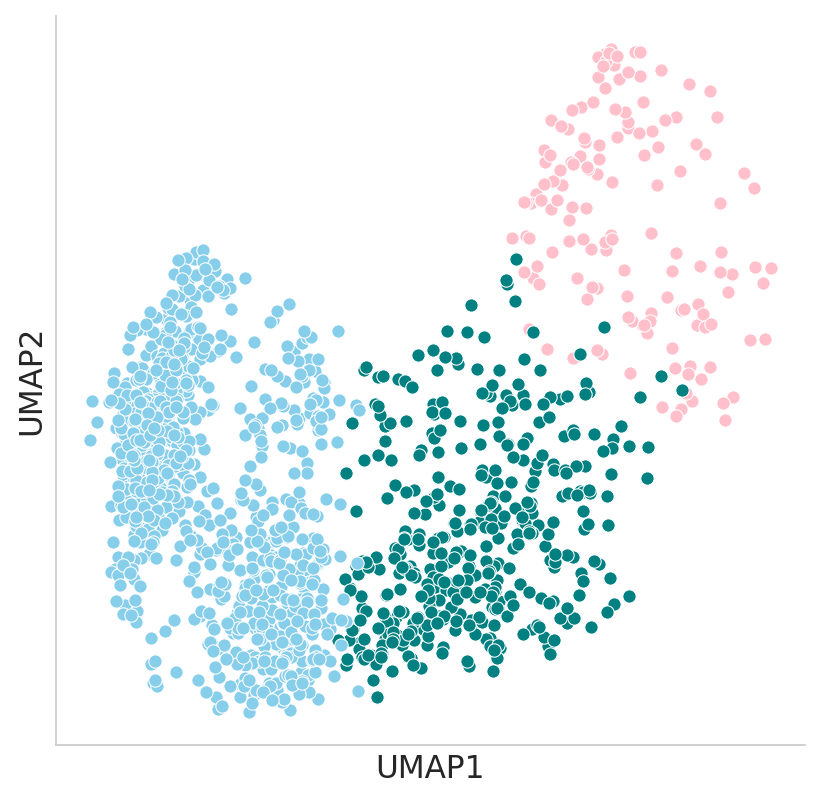

In [31]:
## patient 9
patient = cd8_merge_clean[cd8_merge_clean['patient'] =='10909' ]
patient['clone'] = patient['beta_cdr3'].isin(p3_sum.index)
cd8.obs['clone'] = cd8.obs.index.astype(str).isin(patient[patient['clone'] == True]['index'].values)
cd8.obs['clone'] = cd8.obs['clone'].astype(str)

tmp_df = cd8[cd8.obs['patient'] == '10909']
tmp = pd.DataFrame(tmp_df.obsm['X_umap'])
tmp.index = tmp_df.obs.index
tmp = pd.concat([ tmp, cd8.obs],axis= 1)

plt.subplots(figsize=(6,6))
plt.title('Non-responder 10909')
sns.scatterplot(data  = tmp[tmp['clone'] == 'False'],x =0,y = 1, color = 'lightgrey')
sns.scatterplot(data  = tmp[tmp['clone'] == 'True'],x=0,y =1,  color = 'red')
sns.despine(top = True)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

plt.subplots(figsize=(6,6))
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Effector'],x =0,y = 1, color = 'pink')
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Effector memory'],x=0,y =1,  color = 'teal')
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Stem-like'],x=0,y =1,  color = 'skyblue')
sns.despine(top = True)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

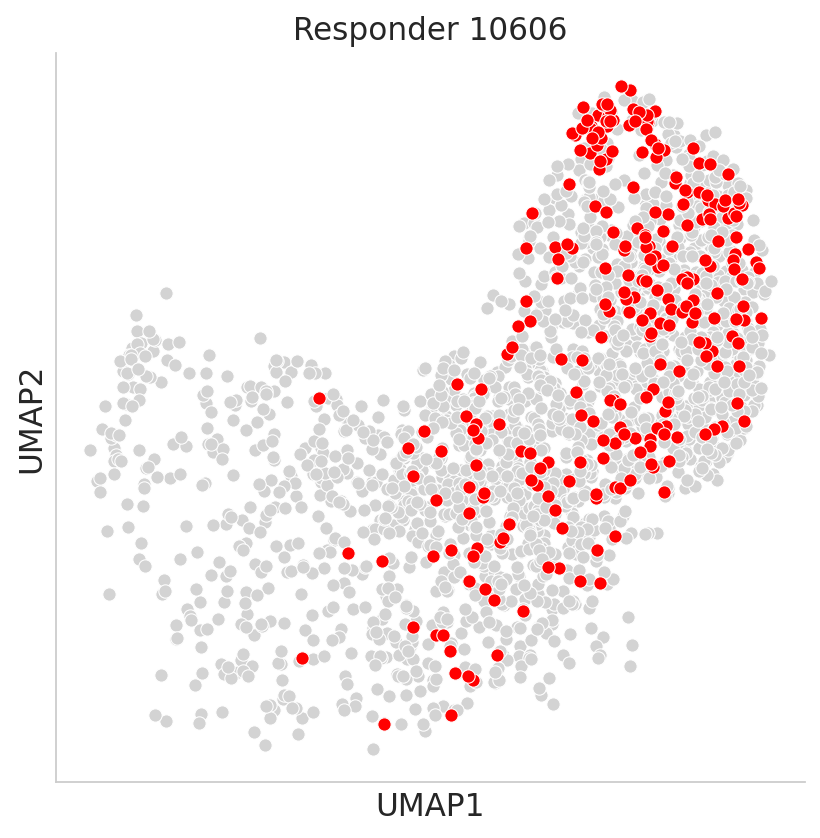

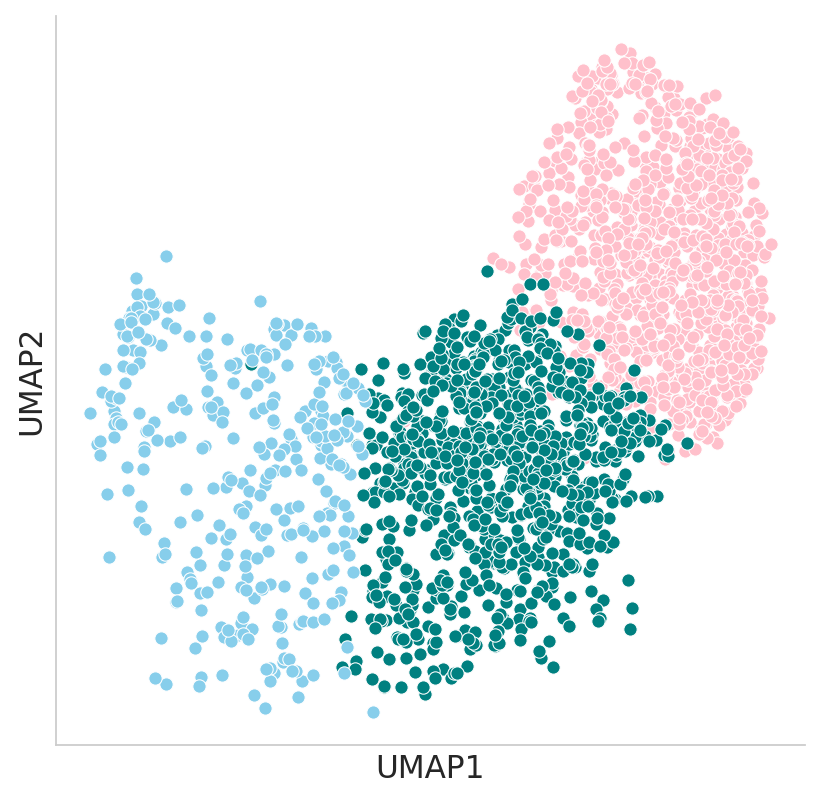

In [30]:
## Patient 6
patient = cd8_merge_clean[cd8_merge_clean['patient'] =='10606' ]
patient['clone'] = patient['beta_cdr3'].isin(p2_sum.index)
cd8.obs['clone'] = cd8.obs.index.astype(str).isin(patient[patient['clone'] == True]['index'].values)
cd8.obs['clone'] = cd8.obs['clone'].astype(str)

tmp_df = cd8[cd8.obs['patient'] == '10606']
tmp = pd.DataFrame(tmp_df.obsm['X_umap'])
tmp.index = tmp_df.obs.index
tmp = pd.concat([ tmp, cd8.obs],axis= 1)

plt.subplots(figsize=(6,6))
plt.title('Responder 10606')
sns.scatterplot(data  = tmp[tmp['clone'] == 'False'],x =0,y = 1, color = 'lightgrey')
sns.scatterplot(data  = tmp[tmp['clone'] == 'True'],x=0,y =1,  color = 'red')
sns.despine(top = True)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

plt.subplots(figsize=(6,6))
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Effector'],x =0,y = 1, color = 'pink')
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Effector memory'],x=0,y =1,  color = 'teal')
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Stem-like'],x=0,y =1,  color = 'skyblue')
sns.despine(top = True)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

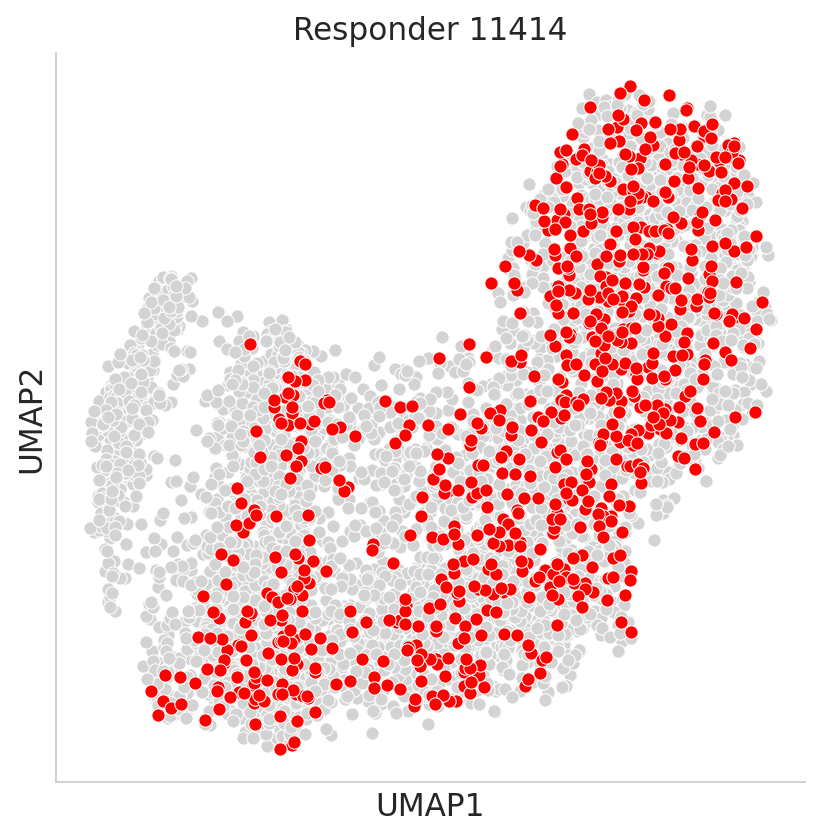

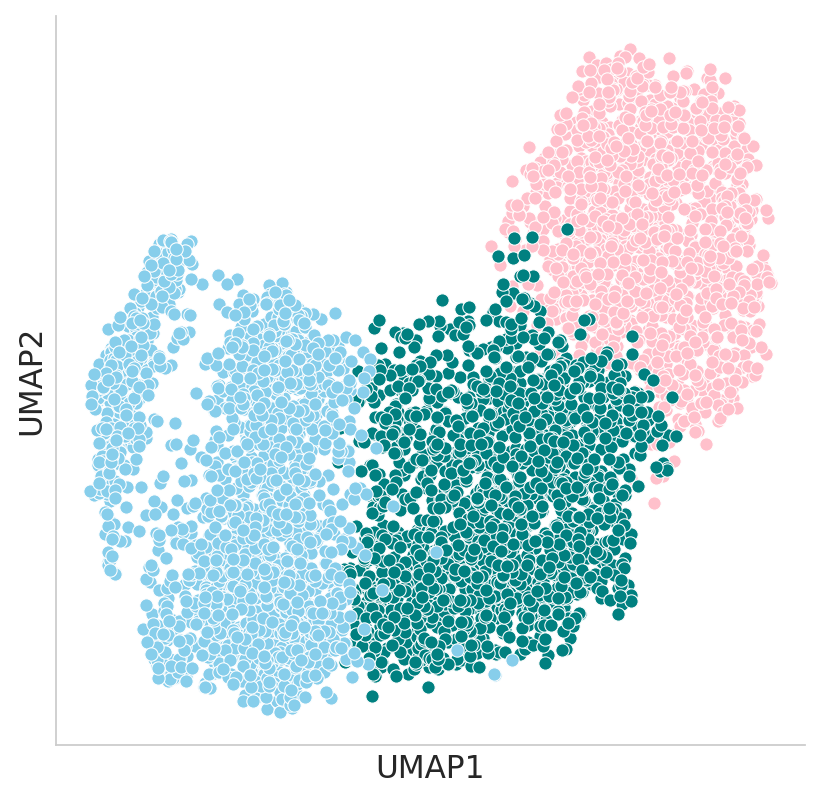

In [29]:
### Patient14 
patient = cd8_merge_clean[cd8_merge_clean['patient'] =='11414' ]
patient['clone'] = patient['beta_cdr3'].isin(p1_sum.index)
cd8.obs['clone'] = cd8.obs.index.astype(str).isin(patient[patient['clone'] == True]['index'].values)
cd8.obs['clone'] = cd8.obs['clone'].astype(str)

tmp_df = cd8[cd8.obs['patient'] == '11414']
tmp = pd.DataFrame(tmp_df.obsm['X_umap'])
tmp.index = tmp_df.obs.index
tmp = pd.concat([ tmp, cd8.obs],axis= 1)

plt.subplots(figsize=(6,6))
plt.title('Responder 11414')
sns.scatterplot(data  = tmp[tmp['clone'] == 'False'],x =0,y = 1, color = 'lightgrey')
sns.scatterplot(data  = tmp[tmp['clone'] == 'True'],x=0,y =1,  color = 'red')
sns.despine(top = True)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

plt.subplots(figsize=(6,6))
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Effector'],x =0,y = 1, color = 'pink')
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Effector memory'],x=0,y =1,  color = 'teal')
sns.scatterplot(data  = tmp[tmp['cellstate'] == 'Stem-like'],x=0,y =1,  color = 'skyblue')
sns.despine(top = True)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()